In [1]:
#
# Extract data from pdf
#

import tempfile, subprocess
import requests

    
def get_pdf(url):
    resp = requests.get(url)
    with tempfile.NamedTemporaryFile() as f:
        f.write(resp.content)
        status, result = subprocess.getstatusoutput(f"pdftotext {f.name} -")
        assert status == 0
        return result


url = 'https://www.mhlw.go.jp/content/10900000/000622162.pdf'
result = get_pdf(url)

In [2]:
#
# Extract data from pdf (contd.) : Manual processing
#

import re
import pandas
import numpy as np; Np = np.array

xx = [x.split('\n') for x in result.split('\n\n')]
yy = [x for x in xx if len(x) > 8]
yy[0] = yy[0][2:]
ww = Np(yy).T
pp = ww[:, 0]
qq = np.vectorize(lambda s: np.int(re.sub('[^\d]', '', s)))(ww[:, 1::2])
df = pandas.DataFrame([pp, *qq.T]).T
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,全 国,3191,3569,3817,4168,4667,5246,5902,6616,7123,7509,7964
1,北海道,193,194,194,198,208,226,239,255,267,272,279
2,青森,11,11,11,11,12,14,14,22,22,22,22
3,岩手,0,0,0,0,0,0,0,0,0,0,0
4,宮城,20,23,26,27,34,36,37,46,52,54,64
5,秋田,10,11,11,11,11,11,12,13,15,15,16
6,山形,6,10,13,19,22,27,27,32,34,35,39
7,福島,14,16,16,24,29,33,36,37,38,38,39
8,茨城,59,64,71,77,77,81,82,91,109,110,116
9,栃木,14,14,14,15,21,31,31,32,35,36,38


Category:  全 国


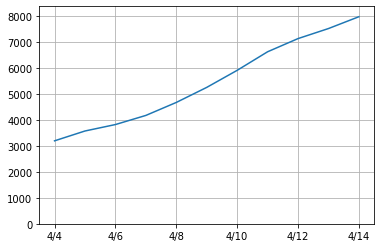

In [3]:
#
# Extract data from pdf (contd.) : Plotting
#

import matplotlib.pyplot as plt
import ipywidgets as ipyw

def _(i=0):
    print("Category: ", pp[i])
    x = np.arange(qq.shape[1])
    y = qq[i, :]

    fig, ax = plt.subplots()
    ax.set(ylim=[0, np.max(y) * 1.05], xticks=x[::2], xticklabels=[f"4/{4 + i}" for i in x][::2])
    ax.grid()
    ax.plot(x, y)

_(0)
# ipyw.interact(_, i=(0, qq.shape[0] - 1, 1))